# "Translating" numbers with seq2seq

In the following we will try to build a translation model from german phrases describing numbers to the corresponding numeric representation (base 10).

This is a toy machine translation task with a very restricted vocabulary and a single valid translation for each source phrase which makes it possible to train on a laptop computer and easier to evaluate. Despite those limitations we expect that this task will highlight interesting properties of Seq2Seq models including:

- the ability to deal with different length of the source and target sequences,
- basic counting and "reasoning" capabilities of LSTM and GRU models.

The parallel text data is generated from a "ground-truth" Python function named `to_german` in the `zahlen` module. It seems to generate reasonably good phrases.

In [1]:
from zahlen import to_german

for x in [21, 42, 80, 81, 88, 300, 213, 1100, 1201, 301000, 80080]:
    print(str(x).rjust(6), to_german(x))

    21 ein und zwanzig
    42 zwei und vierzig
    80 achtzig
    81 ein und achtzig
    88 acht und achtzig
   300 dreihundert
   213 zweihundert und dreizehn
  1100 eintausend einhundert
  1201 eintausend zweihundert und eins
301000 dreihundert und ein tausend
 80080 achtzig tausend und achtzig


## Generating a Training Set

The following will generate 20000 example phrases for numbers between 1 and 1,000,000. We chose to over-represent small numbers by generating all the possible short sequences between `1` and `exhaustive=5000`.

We then split the generated set into non-overlapping train, validation and test splits.

In [1]:
from zahlen import generate
from sklearn.model_selection import train_test_split


numbers, german_numbers = generate(
    20000, low=1, high=int(1e6), exhaustive=5000, seed=0)
num_train, num_dev, de_train, de_dev = train_test_split(
    numbers, german_numbers, test_size=0.5, random_state=0)

num_val, num_test, de_val, de_test = train_test_split(
    num_dev, de_dev, test_size=0.5, random_state=0)

In [2]:
len(de_train), len(de_val), len(de_test)

(10000, 5000, 5000)

In [3]:
for i, de_phrase, num_phrase in zip(range(5), de_train, num_train):
    print(num_phrase.rjust(6), de_phrase)

197906 einhundert sieben und neunzig tausend neunhundert und sechs
660886 sechshundert und sechzig tausend achthundert sechs und achtzig
  2746 zweitausend siebenhundert sechs und vierzig
165370 einhundert fuenf und sechzig tausend dreihundert und siebzig
870470 achthundert und siebzig tausend vierhundert und siebzig


In [4]:
for i, de_phrase, num_phrase in zip(range(5), de_val, num_val):
    print(num_phrase.rjust(6), de_phrase)

124590 einhundert vier und zwanzig tausend fuenfhundert und neunzig
113044 einhundert und dreizehn tausend vier und vierzig
449006 vierhundert neun und vierzig tausend und sechs
723927 siebenhundert drei und zwanzig tausend neunhundert sieben und zwanzig
292178 zweihundert zwei und neunzig tausend einhundert acht und siebzig


## Vocabularies

Build the vocabularies from the training set only. This means there is a chance to have some out-of-vocabulary words in the validation and test sets.

First we need to introduce specific symbols that will be used to:
- pad sequences
- mark the beginning of translation
- mark the end of translation
- be used as a placehold for out-of-vocabulary symbols (not seen in the training set).

Here we use the same convention as the [tensorflow seq2seq tutorial](https://www.tensorflow.org/tutorials/seq2seq):

In [5]:
PAD, GO, EOS, UNK = START_VOCAB = ['_PAD', '_GO', '_EOS', '_UNK']

To build the vocabulary we need to tokenise the sequences of symbols. For the digital number representation we use character level tokenisation while whitespace-based word level tokenisation will do for the German phrases:

In [11]:
def tokenise(sentence, word_level=True):
    if word_level:
        return sentence.split()
    else:
        return [sentence[i:i + 1] for i in range(len(sentence))]

In [12]:
tokenise('1234', word_level=False)

['1', '2', '3', '4']

In [13]:
tokenise('einhundert und dreizehn tausend vier und vierzig', word_level=True)

['einhundert', 'und', 'dreizehn', 'tausend', 'vier', 'und', 'vierzig']

Let's now use this tokenisation strategy to assign a unique integer token ID to each possible token string found in the training set in each language ('German' and 'numeric'): 

In [14]:
def build_vocabulary(tokenised_sequences):
    rev_vocabulary = START_VOCAB[:]
    unique_tokens = set()
    for tokens in tokenised_sequences:
        unique_tokens.update(tokens)
    rev_vocabulary += sorted(unique_tokens)
    vocabulary = {}
    for i, token in enumerate(rev_vocabulary):
        vocabulary[token] = i
    return vocabulary, rev_vocabulary

In [15]:
tokenised_de_train = [tokenise(s, word_level=True) for s in de_train]
tokenised_num_train = [tokenise(s, word_level=False) for s in num_train]

de_vocab, rev_de_vocab = build_vocabulary(tokenised_de_train)
num_vocab, rev_num_vocab = build_vocabulary(tokenised_num_train)

The two languages do not have the same vocabulary sizes:

In [16]:
len(de_vocab)

52

In [17]:
len(num_vocab)

14

In [18]:
for k, v in sorted(de_vocab.items())[:10]:
    print(k.rjust(10), v)
print('...')

      _EOS 2
       _GO 1
      _PAD 0
      _UNK 3
      acht 4
achthundert 5
achttausend 6
  achtzehn 7
   achtzig 8
      drei 9
...


In [19]:
for k, v in sorted(num_vocab.items()):
    print(k.rjust(10), v)

         0 4
         1 5
         2 6
         3 7
         4 8
         5 9
         6 10
         7 11
         8 12
         9 13
      _EOS 2
       _GO 1
      _PAD 0
      _UNK 3


We also built the reverse mappings from token ids to token string representations:

In [20]:
print(rev_de_vocab)

['_PAD', '_GO', '_EOS', '_UNK', 'acht', 'achthundert', 'achttausend', 'achtzehn', 'achtzig', 'drei', 'dreihundert', 'dreissig', 'dreitausend', 'dreizehn', 'ein', 'einhundert', 'eins', 'eintausend', 'elf', 'fuenf', 'fuenfhundert', 'fuenftausend', 'fuenfzehn', 'fuenfzig', 'neun', 'neunhundert', 'neuntausend', 'neunzehn', 'neunzig', 'sechs', 'sechshundert', 'sechstausend', 'sechzehn', 'sechzig', 'sieben', 'siebenhundert', 'siebentausend', 'siebzehn', 'siebzig', 'tausend', 'und', 'vier', 'vierhundert', 'viertausend', 'vierzehn', 'vierzig', 'zehn', 'zwanzig', 'zwei', 'zweihundert', 'zweitausend', 'zwoelf']


In [21]:
print(rev_num_vocab)

['_PAD', '_GO', '_EOS', '_UNK', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Seq2Seq with a single GRU architecture

<img src="basic_seq2seq.png" width="80%" />

From: [Sutskever, Ilya, Oriol Vinyals, and Quoc V. Le. "Sequence to sequence learning with neural networks." NIPS 2014](https://arxiv.org/abs/1409.3215)



Next we need to prepare the inputs for training. For a given source - target sequence pair, we will:
- tokenise the source and target sequences;
- reverse the order of the source sequence;
- create the input sequence by creating a list consisting of the reversed source sequence, the `_GO` token and the target sequence in the original order;
- build the output sequence by appending the `_EOS` token to the source sequence.

Let's do this as a function using the original string representations for the tokens so as to make it easier to debug:

**Exercise**
- Write a function that turns a pair of tokenized (source, target) sequences into a pair of (input, output) sequences as described above.
- The function should have a `reverse_source=True` as an option so we can experiment with not reversing the source sequence.

Notes: 
- The function should output two list of string tokens: one to be fed in as the input and the other as expected output for the seq2seq network.
- Do not pad the sequences: we will handle the padding later.
- Don't forget to insert the `_GO` and `_EOS` special symbols at the correct locations.

In [22]:
def make_input_output(source_tokens, target_tokens, reverse_source=True):
    if reverse_source:
        source_tokens = source_tokens[::-1]
    input_tokens = source_tokens + [GO] + target_tokens
    output_tokens = target_tokens + [EOS]
    return input_tokens, output_tokens

In [26]:
input_tokens, output_tokens = make_input_output(
    ['ein', 'hundert', 'und', 'eins'],
    ['1', '2', '1'],
)
# Expected outputs:
# ['eins', 'und', 'hundert', 'ein', '_GO', '1', '2', '1']
# ['1', '2', '1', '_EOS']

In [27]:
input_tokens

['eins', 'und', 'hundert', 'ein', '_GO', '1', '2', '1']

In [28]:
output_tokens

['1', '2', '1', '_EOS']

### Vectorisation of the parallel corpus

Let's apply the previous transformation to each pair of (source, target) sequene and use a shared vocabulary to store the results in numpy arrays of integer token IDs, with padding on the left so that all input / output sequences have the same length:

In [29]:
all_tokenised_sequences = tokenised_de_train + tokenised_num_train
shared_vocab, rev_shared_vocab = build_vocabulary(all_tokenised_sequences)

In [31]:
max(len(s) for s in tokenised_de_train)

9

In [32]:
max(len(s) for s in tokenised_num_train)

6

In [38]:
import numpy as np
# found by introspection of our training set
# max DE train length + max numeric train lenght + 1 token
max_length = 9 + 6 + 1

def vectorise_corpus(source_sequences, target_sequences, shared_vocab,
                     word_level_source=True, word_level_target=True,
                     max_length=max_length):
    assert len(source_sequences) == len(target_sequences)
    n_sequences = len(source_sequences)
    # a numpy array to store the source tokens
    source_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    # set everything to represent "PADDING"
    source_ids.fill(shared_vocab[PAD])
    # place to store the target tokens
    target_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    target_ids.fill(shared_vocab[PAD])

    numbered_pairs = zip(range(n_sequences), source_sequences, target_sequences)
    for i, source_seq, target_seq in numbered_pairs:
        source_tokens = tokenise(source_seq, word_level=word_level_source)
        target_tokens = tokenise(target_seq, word_level=word_level_target)
        
        in_tokens, out_tokens = make_input_output(source_tokens, target_tokens)
        
        in_token_ids = [shared_vocab.get(t, UNK) for t in in_tokens]
        source_ids[i, -len(in_token_ids):] = in_token_ids
    
        out_token_ids = [shared_vocab.get(t, UNK) for t in out_tokens]
        target_ids[i, -len(out_token_ids):] = out_token_ids
    return source_ids, target_ids

In [39]:
X_train, Y_train = vectorise_corpus(de_train, num_train, shared_vocab,
                                    word_level_target=False)

In [40]:
X_train.shape

(10000, 16)

In [41]:
X_train[0]

array([ 0, 39, 50, 35, 49, 38, 50, 44, 25,  1,  5, 13, 11, 13,  4, 10], dtype=int32)

In [42]:
Y_train.shape

(10000, 16)

In [44]:
de_train[0]

'einhundert sieben und neunzig tausend neunhundert und sechs'

In [45]:
num_train[0]

'197906'

In [46]:
X_train[0]

array([ 0, 39, 50, 35, 49, 38, 50, 44, 25,  1,  5, 13, 11, 13,  4, 10], dtype=int32)

In [47]:
Y_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 13, 11, 13,  4, 10,  2], dtype=int32)

This looks good. In particular we can note:

- the PAD=0 symbol at the beginning of the two sequences,
- the input sequence has the GO=1 symbol to separate the source from the target,
- the output sequence is a shifted version of the target and ends with EOS=2.

Let's vectorise the validation and test set to be able to evaluate our models:

In [48]:
X_val, Y_val = vectorise_corpus(de_val, num_val, shared_vocab,
                                word_level_target=False)
X_test, Y_test = vectorise_corpus(de_test, num_test, shared_vocab,
                                  word_level_target=False)

In [49]:
X_val.shape, Y_val.shape

((5000, 16), (5000, 16))

In [50]:
X_test.shape, Y_test.shape

((5000, 16), (5000, 16))

### A simple Seq2Seq architecture

To keep the architecture simple we will use the same RNN model and weights for both the encoder part (before the `_GO` token) and the decoder part (after the `_GO` token).

We are using the GRU recurrent cell instead of a LSTM because it is slightly faster to compute and should give comparable results.

Building a Seq2Seq model:
  - Starting with an Embedding layer;
  - Then a single GRU layer: the GRU layer should yield a sequence of output vectors, one at each timestep;
  - Then a Dense layer to adapt the ouput dimension of the GRU layer to the dimension of the output vocabulary;
  - Don't forget to insert some Dropout layer(s), especially after the Embedding layer.

Note:
- The output dimension of the Embedding layer should be smaller than usual because we have small vocabulary size;
- The dimension of the GRU should be larger to give the Seq2Seq model enough "working memory" to memorize the full input sequence before decoding it;
- Your model should output a shape `[batch, sequence_length, vocab_size]`.

In [98]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, GRU, Dense

vocab_size = len(shared_vocab)
simple_seq2seq = Sequential()
simple_seq2seq.add(Embedding(vocab_size, 32, input_length=max_length))
simple_seq2seq.add(Dropout(0.2))
simple_seq2seq.add(GRU(256, return_sequences=True))
simple_seq2seq.add(Dense(vocab_size, activation='softmax'))

# We use the sparse_categorical_crossentropy loss to be able to pass
# integer-coded output for the token IDs without having to convert to one-hot
# codes first
simple_seq2seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

**Questions**:

- What is the expected shape of the output of the model when we feed it with an input of 16 tokens? What is the meaning of the values in the output of the model?
- What is the shape of the output of each layer in the model?

In [99]:
X_train[0].shape

(16,)

In [100]:
simple_seq2seq.predict(X_train[0:1]).shape

(1, 16, 62)

In [101]:
simple_seq2seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 32)            1984      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 32)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16, 256)           221952    
_________________________________________________________________
dense_2 (Dense)              (None, 16, 62)            15934     
Total params: 239,870
Trainable params: 239,870
Non-trainable params: 0
_________________________________________________________________


Let's register a callback to automatically snapshot the best model by measuring the performance of the model on the validation set at the end of each epoch during training:

In [102]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


best_model_fname = "simple_seq2seq_checkpoint.h5"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_loss',
                                save_best_only=True, verbose=1)

We need to use the `np.expand_dims` trick on Y: this is required by Keras because if we use a sparse (integer-based) representation for the output:

Train on 10000 samples, validate on 5000 samples
Epoch 1/90
 - 12s - loss: 1.1229 - val_loss: 0.8007

Epoch 00001: val_loss improved from inf to 0.80065, saving model to simple_seq2seq_checkpoint.h5
Epoch 2/90
 - 11s - loss: 0.7805 - val_loss: 0.7631

Epoch 00002: val_loss improved from 0.80065 to 0.76312, saving model to simple_seq2seq_checkpoint.h5
Epoch 3/90
 - 11s - loss: 0.7451 - val_loss: 0.7054

Epoch 00003: val_loss improved from 0.76312 to 0.70539, saving model to simple_seq2seq_checkpoint.h5
Epoch 4/90
 - 11s - loss: 0.6745 - val_loss: 0.6243

Epoch 00004: val_loss improved from 0.70539 to 0.62432, saving model to simple_seq2seq_checkpoint.h5
Epoch 5/90
 - 11s - loss: 0.5989 - val_loss: 0.5345

Epoch 00005: val_loss improved from 0.62432 to 0.53448, saving model to simple_seq2seq_checkpoint.h5
Epoch 6/90
 - 11s - loss: 0.5119 - val_loss: 0.4515

Epoch 00006: val_loss improved from 0.53448 to 0.45153, saving model to simple_seq2seq_checkpoint.h5
Epoch 7/90
 - 11s - loss: 0.425


Epoch 00066: val_loss did not improve from 0.00052
Epoch 67/90
 - 11s - loss: 0.0014 - val_loss: 0.0012

Epoch 00067: val_loss did not improve from 0.00052
Epoch 68/90
 - 11s - loss: 0.0031 - val_loss: 0.0018

Epoch 00068: val_loss did not improve from 0.00052
Epoch 69/90
 - 13s - loss: 0.0036 - val_loss: 0.0017

Epoch 00069: val_loss did not improve from 0.00052
Epoch 70/90
 - 11s - loss: 0.0041 - val_loss: 0.0012

Epoch 00070: val_loss did not improve from 0.00052
Epoch 71/90
 - 12s - loss: 0.0040 - val_loss: 0.0013

Epoch 00071: val_loss did not improve from 0.00052
Epoch 72/90
 - 12s - loss: 0.0014 - val_loss: 7.4480e-04

Epoch 00072: val_loss did not improve from 0.00052
Epoch 73/90
 - 13s - loss: 8.4343e-04 - val_loss: 5.5346e-04

Epoch 00073: val_loss did not improve from 0.00052
Epoch 74/90
 - 12s - loss: 0.0014 - val_loss: 0.0014

Epoch 00074: val_loss did not improve from 0.00052
Epoch 75/90
 - 12s - loss: 0.0016 - val_loss: 0.0017

Epoch 00075: val_loss did not improve from

Text(0.5,1,'Convergence plot for Simple Seq2Seq')

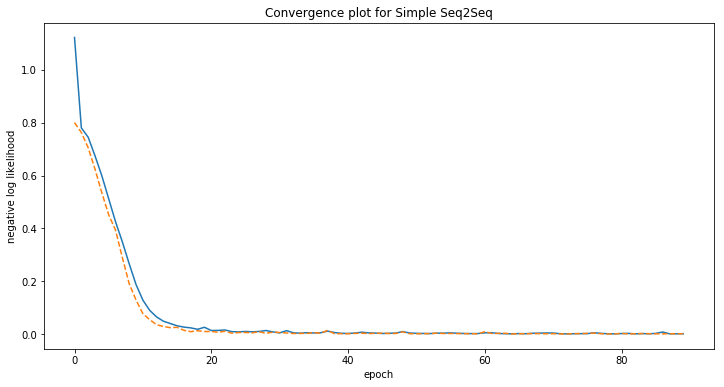

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

history = simple_seq2seq.fit(X_train, np.expand_dims(Y_train, -1),
                             validation_data=(X_val, np.expand_dims(Y_val, -1)),
                             epochs=90, verbose=2, batch_size=32,
                             callbacks=[best_model_cb])

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], '--', label='validation')
plt.ylabel('negative log likelihood')
plt.xlabel('epoch')
plt.title('Convergence plot for Simple Seq2Seq')

Let's load the best model found on the validation set at the end of training:

In [105]:
loaded_simple_seq2seq = load_model(best_model_fname)

Let's see how wel our model does on this fairly simple task. For anything reasonable we should train for mayb 50 epochs. To get rid of errors probably train for 150 epochs.

Let's have a look at a raw prediction on the first sample of the test set:

In [104]:
de_test[0]

'achthundert ein und neunzig tausend einhundert und drei'

In the numeric array this is provided (along with the expected target sequence) as the following padded input sequence:

In [106]:
first_test_sequence = X_test[0:1]
first_test_sequence

array([[ 0, 19, 50, 25, 49, 38, 50, 24, 15,  1, 12, 13,  5,  5,  4,  7]], dtype=int32)

Maybe scroll up to find the table translating integer tokens into the actual numbers.

Remember that the `_GO` (symbol indexed at `1`) separates the reversed source from the expected target sequence:  

In [107]:
rev_shared_vocab[1]

'_GO'

### Interpreting the model prediction

Let's feed a test sequence into the model. For each predicted output we get the argmax (to get the most likely symbol) and put that into our output.

We also have to get rid of our padding and turn it back into a human friendly text.

In [108]:
prediction = simple_seq2seq.predict(first_test_sequence)
print("prediction shape:", prediction.shape)

# Let's use `argmax` to extract the predicted token ids at each step.
# what does the last dimension stand for?
predicted_token_ids = prediction[0].argmax(-1)
print("prediction token ids:", predicted_token_ids)

# We can use the shared reverse vocabulary to map
# the integer sequence back to the string representation of the tokens,
# as well as removing Padding and EOS symbols
predicted_numbers = [rev_shared_vocab[token_id] for token_id in predicted_token_ids
                     if token_id not in (shared_vocab[PAD], shared_vocab[EOS])]
print("predicted number:", "".join(predicted_numbers))
print("test number:", num_test[0])


prediction shape: (1, 16, 62)
prediction token ids: [ 0  0  0  0  0  0  0  0  0 12 13  5  5  4  7  2]
predicted number: 891103
test number: 891103


Woohhaayy!! But wait ...

In the previous notebook cell we cheated because we gave the complete test sequence to the network as input. Along with the solution!

To be more realistic we need to use the model in a setting where we do not provide any token of the expected translation as part of the input sequence: the model has to predict one token at a time starting only from the source sequence along with the `<GO>` special symbol. At each step, we append the newly predicted output token to the input sequence to predict the next token:

In [111]:
def greedy_translate(model, source_sequence, shared_vocab, rev_shared_vocab,
                     word_level_source=True, word_level_target=True):
    """Greedy decoder that predicts one token at a time"""
    # Initialise the list of input token IDs with the source sequence
    source_tokens = tokenise(source_sequence, word_level=word_level_source)

    input_ids = [shared_vocab.get(t, UNK) for t in reversed(source_tokens)]
    input_ids += [shared_vocab[GO]]

    # Prepare a fixed size numpy array that matches the expected input
    # shape for the model
    input_array = np.empty(shape=(1, model.input_shape[1]),
                           dtype=np.int32)
    #print(input_array)
    decoded_tokens = []
    while len(input_ids) <= max_length:
        # Vectorise the list of input tokens
        # and use zero padding.
        input_array.fill(shared_vocab[PAD])
        # clever numpy indexing to set the last part of input_array
        input_array[0, -len(input_ids):] = input_ids
        
        # Predict the next output: greedily decoding with argmax
        # we pick the token with the highest probability at this step
        next_token_id = model.predict(input_array)[0, -1].argmax()
        
        # Stop decoding if the network predicts "end of sentence":
        if next_token_id == shared_vocab[EOS]:
            #print("done")
            break
            
        # Otherwise use the reverse vocabulary to map the prediction
        # back to the string space
        decoded_tokens.append(rev_shared_vocab[next_token_id])
        
        # Append prediction to input sequence to predict the next token
        input_ids.append(next_token_id)

    separator = " " if word_level_target else ""
    return separator.join(decoded_tokens)

In [121]:
phrases = [
    "eins",
    "zwei",
    "drei",
    "zwoelf",
    "fuenfzehn",
    "einhundert sieben und neunzig tausend neunhundert und sechs",
    "siebenhundert drei und zwanzig tausend neunhundert sieben und zwanzig",
    "zwei und vierzig",
    "dreihundert zwei und zwanzig"
]
for phrase in phrases:
    translation = greedy_translate(#loaded_simple_seq2seq,
        simple_seq2seq,
                                   phrase,
                                   shared_vocab, rev_shared_vocab,
                                   word_level_target=False)
    print(phrase.ljust(20), translation)

eins                 1
zwei                 2
drei                 3
zwoelf               12
fuenfzehn            15
einhundert sieben und neunzig tausend neunhundert und sechs 197906
siebenhundert drei und zwanzig tausend neunhundert sieben und zwanzig 147927
zwei und vierzig     42
dreihundert zwei und zwanzig 422


If you train the model long enough (~100 epochs) you should be getting pretty good results. After only 15 epochs the network mostly just predicts the `<EOS>` token so it might look like it is not outputting anything/broken.

## Model evaluation

Because we expect only one correct translation for a given source sequence, we can use phrase-level accuracy as a metric to quantify our model quality.

Note that this is not the case for real translation models (e.g. from French to English on arbitrary sentences). Evaluation of a machine translation model in general is tricky. Automated evaluation can be done at the corpus level with the [BLEU score](https://en.wikipedia.org/wiki/BLEU) (bilingual evaluation understudy) given a large enough sample of correct translations provided by certified translators but its only a noisy proxy.

The only good evaluation is to give a large enough sample of the model predictions on some test sentences to certified translators and ask them to give an evaluation (e.g. a score between 0 and 6, 0 for non-sensical and 6 for the hypothetical perfect translation). However in practice this is very costly to do, so you will almost always see BLEU scores quoted in papers.

Fortunately we can just use phrase-level accuracy on a our very domain specific toy problem:

In [123]:
def phrase_accuracy(model, num_sequences, de_sequences, n_samples=500,
                    decoder_func=greedy_translate):
    correct = []
    n_samples = len(num_sequences) if n_samples is None else n_samples
    for i, num_seq, de_seq in zip(range(n_samples), num_sequences, de_sequences):
        if i % 100 == 0:
            print("Decoding %d/%d" % (i, n_samples))

        predicted_seq = decoder_func(simple_seq2seq, de_seq,
                                     shared_vocab, rev_shared_vocab,
                                     word_level_target=False)
        correct.append(num_seq == predicted_seq)
        #if num_seq != predicted_seq:
        #    print(num_seq, predicted_seq)
    return np.mean(correct)

In [124]:
print("Phrase-level train accuracy: %0.3f"
      % phrase_accuracy(simple_seq2seq, num_train, de_train))

Decoding 0/500
Decoding 100/500
Decoding 200/500
Decoding 300/500
Decoding 400/500
Phrase-level train accuracy: 0.318


In [125]:
print("Phrase-level test accuracy: %0.3f"
      % phrase_accuracy(simple_seq2seq, num_test, de_test))

Decoding 0/500
Decoding 100/500
Decoding 200/500
Decoding 300/500
Decoding 400/500
Phrase-level test accuracy: 0.360


In [126]:
print("Phrase-level test accuracy: %0.3f"
      % phrase_accuracy(loaded_simple_seq2seq, num_test, de_test))

Decoding 0/500
Decoding 100/500
Decoding 200/500
Decoding 300/500
Decoding 400/500
Phrase-level test accuracy: 0.360


# Summary

seq2seq models are very powerful. You can translate from any kind of sequence to another sequence. This could be Numeric to German, German to Numeric, GitHub issue text to GitHub title, Python docstring to Python source code, ... or German to Klingon.

There are a lot of details and tricks of the trade that we skipped over here. If you want to dive deeper follow some of the links below.


# Going Further

We only scratched the surface of sequence-to-sequence systems. To go further, read the initial [Sequence to Sequence paper](https://arxiv.org/abs/1409.3215) as well as the following developments, citing this work. Furthermore, here are a few pointers on how to go further if you're interested.

### Improved model

- implement [beam-search](https://en.wikipedia.org/wiki/Beam_search) instead of our greedy decoding.
- Add multiple, larger GRU layers and more dropout regularization.
- This should make it possible train a perfect translation model with a smaller amount of labeled samples. Try to train a seq2seq model with only 4000 training sequences or even fewer without overfitting.
- You will need a GPU and more training time for that...

### Reverse translation: Numeric to German

- Build a model, with the same data from Numeric to German
- The model should work well with the same kind of architecture as for German to Numeric


### Separated Encoder-Decoder

You may want to build a model with a separated encoder and decoder, to improve performance and to have more flexiblity with the architecture.

With Keras, you can get access to the activation states of the LSTM cell by using:

```python
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]
```

then you can reuse those states to initialize the state of the decoder cell:

```python
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
```

A full example of this architecture can be found at:

- https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py

TensorFlow also has some nice examples: https://www.tensorflow.org/tutorials/seq2seq.

The opennmt project is worth looking at too: http://opennmt.net/